# Part 1 (10 points): Automated SMS spam filtering

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


## Step 1: Load data, look around

Skipping the *real* first step (fleshing out specs, finding out what is it we want to be doing -- often highly non-trivial in practice!), let's download the dataset we'll be using in this demo. Go to https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection and download the zip file. Unzip it under `data` subdirectory. You should see a file called `SMSSpamCollection`, about 0.5MB in size:

```bash
$ ls -l data
total 1352
-rw-r--r--@ 1 kofola  staff  477907 Mar 15  2011 SMSSpamCollection
-rw-r--r--@ 1 kofola  staff    5868 Apr 18  2011 readme
-rw-r-----@ 1 kofola  staff  203415 Dec  1 15:30 smsspamcollection.zip
```

This file contains **a collection of more than 5 thousand SMS phone messages** (see the `readme` file for more info):

In [2]:
messages = [line.rstrip() for line in open('SMSSpamCollection.txt')]
len(messages)

5574

A collection of texts is also sometimes called "corpus". Let's print the first ten messages in this SMS corpus:

In [3]:
for message_no, message in enumerate(messages[:10]):
    print (message_no, message)

(0, 'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')
(1, 'ham\tOk lar... Joking wif u oni...')
(2, "spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's")
(3, 'ham\tU dun say so early hor... U c already then say...')
(4, "ham\tNah I don't think he goes to usf, he lives around here though")
(5, "spam\tFreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, \xc2\xa31.50 to rcv")
(6, 'ham\tEven my brother is not like to speak with me. They treat me like aids patent.')
(7, "ham\tAs per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune")
(8, 'spam\tWINNER!! As a valued network customer you have been selected to receivea \xc2\xa3900 pr

We see that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("tab separated values") file, where the first column is a label saying whether the given message is a normal message ("ham") or "spam". The second column is the message itself.

This corpus will be our labeled training set. Using these ham/spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

[![](http://radimrehurek.com/data_science_python/plot_ML_flow_chart_11.png)](http://www.astroml.org/sklearn_tutorial/general_concepts.html#supervised-learning-model-fit-x-y)

Instead of parsing TSV (or CSV, or Excel...) files by hand, we can use Python's `pandas` library to do the work for us:

In [4]:
messages = pandas.read_csv('SMSSpamCollection.txt', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print (messages)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
6      ham  Even my brother is not like to speak with me. ...
7      ham  As per your request 'Melle Melle (Oru Minnamin...
8     spam  WINNER!! As a valued network customer you have...
9     spam  Had your mobile 11 months or more? U R entitle...
10     ham  I'm gonna be home soon and i don't want to tal...
11    spam  SIX chances to win CASH! From 100 to 20,000 po...
12    spam  URGENT! You have won a 1 week FREE membership ...
13     ham  I've been searching for the right words to tha...
14     ham                I HAVE A DATE ON SUNDAY WITH WILL!!
15    sp

With `pandas`, we can also view aggregate statistics easily:

In [5]:
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4827
      unique                                               4518
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

How long are the messages?

In [6]:
messages['length'] = messages['message'].map(lambda text: len(text))
print (messages.head())

  label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


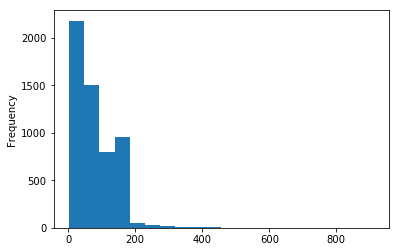

In [7]:
messages.length.plot(bins=20, kind='hist');

In [8]:
messages.length.describe()

count    5574.000000
mean       80.604593
std        59.919970
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

What is that super long message?

In [9]:
print (list(messages.message[messages.length > 900]))

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


In [10]:
print (list(messages[messages.length > 900].index))

[1085]


Is there any difference in message length between spam and ham?

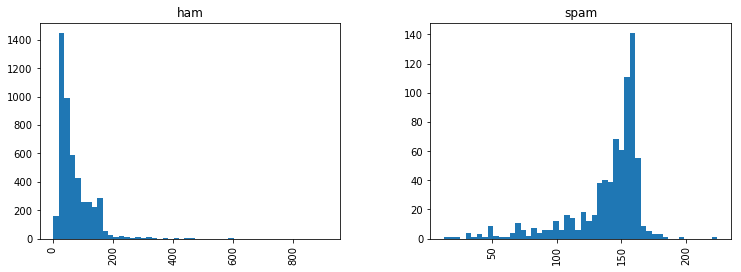

In [11]:
messages.hist(column='length', by='label', bins=50, figsize=(12,4));

Good fun, but how do we make computer understand the plain text messages themselves? Or can it under such malformed gibberish at all?

## Step 2: Data to vectors

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the bag-of-words model:

1. counting how many times does a word occur in each message (term frequency)
2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

Each vector has as many dimensions as there are unique words in the SMS corpus.

To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [44]:
vectorizer = TfidfVectorizer()
sms_tfidf = vectorizer.fit_transform(messages['message'].values)

print(sms_tfidf.shape)

(5574, 8713)


#### Question 1 (02 points): You must to analyze the new dataset and explain (a)its structure and (b) the meaning of the values.
El nuevo dataset esta estructurado en una matriz de correspondencia de una tupla (n,t) a un valor f(n,t).
Donde n es el numero del mensaje en el dataset, t es el numero asignado a alguna palabra, y f(n,t) es el TF-IDF calculado a partir de n y t.

Asi, sms_tfidf.shape nos dice que hay 5574 mensajes, en los cuales hay 8713 diferentes palabras.

## Step 3: Training a model, detecting spam

With messages represented as vectors, we can finally train our spam/ham classifier. This part is pretty straightforward, and there are many libraries that realize the training algorithms.
The library sklearn.naive_bayes includes implementations of three Naïve Bayes classifiers
- GaussianNB
- MultinomialNB 
- BernoulliNB

#### Question 2 (02 points): We will use MultinomialNB, why? 

Esto es debido a que el clasificador Multinomial es adecuado para valores discretos, como la cuenta de palabaras en un documento. Aunque utilizaremos un valor discreto (TF-IDF), este sigue resultando ser el más adecuado.

#### Question 3 (02 points): When are used the other two NB versions? 
El clasificador Gausiano es utilizado cuando podemos asumir que la distribucion de probabilidad es normal.
Por otro lado, el clasificador Bernoulli es utilizado cuando se trabaja con valores booleanos como determinantes de nuestro algoritmo. (en este caso, TF-IDF no es booleano, sino continuo).

In [75]:
classifier1 = MultinomialNB()
targets = messages['label'].values
clf1 = classifier1.fit(sms_tfidf, targets)
classifier2 = MultinomialNB(0,True,None)
clf2 = classifier2.fit(sms_tfidf, targets)
classifier3 = MultinomialNB(1.0,False,None)
clf3 = classifier3.fit(sms_tfidf, targets)

Let's try classifying our single random message:

In [76]:
examples = ['You just won a prize!', 'Hello my friend']
example_vector = vectorizer.transform(examples)
predictions = classifier.predict(example_vector)

print(predictions)

['spam' 'ham']


Hooray! You can try it with your own texts, too.

A natural question is to ask, how many messages do we classify correctly overall?

In [77]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

all_predictions = clf1.predict(sms_tfidf)
accuracy = accuracy_score(messages['label'], all_predictions)
cm = confusion_matrix(messages['label'], all_predictions)
statistics = classification_report(messages['label'], all_predictions)

print('Accuracy: %.4f\n' % accuracy)
print('Confusion matrix:\n%s\n' % pandas.DataFrame(cm))
print(statistics)

all_predictions = clf2.predict(sms_tfidf)
accuracy = accuracy_score(messages['label'], all_predictions)
cm = confusion_matrix(messages['label'], all_predictions)
statistics = classification_report(messages['label'], all_predictions)

print('Accuracy: %.4f\n' % accuracy)
print('Confusion matrix:\n%s\n' % pandas.DataFrame(cm))
print(statistics)

all_predictions = clf3.predict(sms_tfidf)
accuracy = accuracy_score(messages['label'], all_predictions)
cm = confusion_matrix(messages['label'], all_predictions)
statistics = classification_report(messages['label'], all_predictions)

print('Accuracy: %.4f\n' % accuracy)
print('Confusion matrix:\n%s\n' % pandas.DataFrame(cm))
print(statistics)

Accuracy: 0.9761

Confusion matrix:
      0    1
0  4827    0
1   133  614

             precision    recall  f1-score   support

        ham       0.97      1.00      0.99      4827
       spam       1.00      0.82      0.90       747

avg / total       0.98      0.98      0.98      5574

Accuracy: 0.9998

Confusion matrix:
      0    1
0  4827    0
1     1  746

             precision    recall  f1-score   support

        ham       1.00      1.00      1.00      4827
       spam       1.00      1.00      1.00       747

avg / total       1.00      1.00      1.00      5574

Accuracy: 0.9840

Confusion matrix:
      0    1
0  4772   55
1    34  713

             precision    recall  f1-score   support

        ham       0.99      0.99      0.99      4827
       spam       0.93      0.95      0.94       747

avg / total       0.98      0.98      0.98      5574



#### Question 4 (02 points): By default, MultinomialNB uses the Additive Laplace smoothing. Change the classifier to work without smoothing. Explain new results comparing with the default version.

El clasificador sin Suavizado de Laplace resulta tener un Accuracy mayor (0.9998 en comparación de 0.9761).
Esto es debido a que no estamos trabajando con un nuevo dataset para testar nuestra data. Envés, estamos utilizando el mismo dataset que usamos para entrenar al algoritmo para testearlo.

Esto significa que no existirán nuevas palabras encontradas cuando exploremos nuestro test_dataset.
La suavización de Laplace es utilizada para no dividir entre 0 cuando se encuentra una nueva palabra.

De esta manera, al utilizar la suavizacion aditiva, estamos suavizando nuestros datos (perdiendo diferenciacion entre ellos) a cambio de ninguna ganancia.

#### Question 5 (02 points): How are computed the prior probabilities, with default parameters? Change the classifier to work with uniform prior probabilities. Explain new results comparing with the default version.
Con parametros por default, las probabilidades a priori son calculadas. En la ultima ejecucion (classifier3), las probabilidades a priori fueron uniformes para cada dato.

En comparacion con classfier1, este cambio aumenta el Accuracy. Esto es debido a que un calculo a priori de las probabilidades de cada clase depende que nuestros datos sigan algun tipo de distribucion fija. Sin embargo, como este no es el caso, es mejor no utilizar probabilidades a priori.

# Part 2 (10 points): Automated mail spam detection

* Repeat all previous stept, this time using a more complex corpus: mails dataset. Go to  http://www.aueb.gr/users/ion/data/enron-spam/ and download the Enron4 file, which is composed of two directories (ham and spam). You must to create the mail-class matrix in order to classify ham and spam mails, following the same steps of sms spam problem.

In [108]:
"".join(["asd", " xx"])

'asd xx'

In [127]:
import os
import codecs
import numpy as np
import pandas as pd

ham_folder = 'enron4/ham/'
spam_folder = 'enron4/spam/'

ham_files = [os.path.join(ham_folder, f) for f in os.listdir(ham_folder)]
spam_files = [os.path.join(spam_folder, f) for f in os.listdir(spam_folder)]

# Para abrir los files se necesita un encoding especial:
##open(ham_files[3], encoding='iso-8859-7')

##Crear nuestro directorio gigante de mensajes con spam y con ham
mensajes=[]
for archivo in ham_files:
    doc=[]
    for linea in codecs.open(archivo, encoding='iso-8859-7'):
        doc= doc + list(linea.rstrip())

    doc= "".join(doc)
    mensajes.append(doc)
for archivo in spam_files:
    doc=[]
    for linea in codecs.open(archivo, encoding='iso-8859-7'):
        doc= doc + list(linea.rstrip())

    doc= "".join(doc)
    mensajes.append(doc)
##Crear un arreglo dondo los 1500 primeros son ham y 4500 son spam
labels=[]
for _ in range(1500):
    labels.append("ham");
for _ in range(4500):
    labels.append("spam");

In [128]:
#Datos a vectores
vectorizer = TfidfVectorizer()
sms_tfidf = vectorizer.fit_transform(mensajes)
print(sms_tfidf.shape)

(6000, 95038)


In [129]:
#Entrar modelo usando clasificador multinomial sin suavizacion, dado que lo probaremos en el mismo dataset con el que
#lo entrenaremos
targets = labels
classifier = MultinomialNB(0,True,None)
clf = classifier.fit(sms_tfidf, targets)

In [130]:
#Probar modelo con ejemplitos
examples = ['You just won a prize!']
example_vector = vectorizer.transform(examples)
predictions = classifier.predict(example_vector)

print(predictions)

['spam']


In [132]:
#Conseguir data del algoritmo, probandolo en el mismo dataset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

all_predictions = clf.predict(sms_tfidf)
accuracy = accuracy_score(labels, all_predictions)
cm = confusion_matrix(labels, all_predictions)
statistics = classification_report(labels, all_predictions)

print('Accuracy: %.4f\n' % accuracy)
print('Confusion matrix:\n%s\n' % pandas.DataFrame(cm))
print(statistics)

Accuracy: 0.9995

Confusion matrix:
      0     1
0  1500     0
1     3  4497

             precision    recall  f1-score   support

        ham       1.00      1.00      1.00      1500
       spam       1.00      1.00      1.00      4500

avg / total       1.00      1.00      1.00      6000

